# Chapter 3. Classification

## 0. Import Libraries & Helper Functions

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## MNIST Dataset

In [10]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, parser='auto')

In [11]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [12]:
X, y = mnist["data"], mnist["target"]

print(f"X Shape: {X.shape}, y Shape: {y.shape}")

X Shape: (70000, 784), y Shape: (70000,)


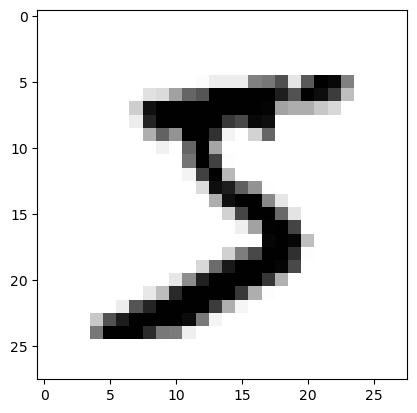

In [15]:
some_digit = X[0:1]
some_digit_image=some_digit.values.reshape(28,28)
plt.imshow(some_digit_image,cmap='binary')

In [16]:
print(f"Label: {y[0]}")
y = y.astype(np.uint8)

y[0]

Label: 5


5

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], X[:60000]

## Binary Classifier

Let's simplify the problem and only try to identify whether the input is the number 5, which we call a "5_detector".

In [18]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

In [19]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
sgd_clf.predict(some_digit)

array([ True])

## Performance Measures

### Confusion Matrix

A great way to evaluate the performance of a classifier is via a confusion matrix.

The general idea is to evalute the the number of times class A was was labled as class B, and vice versa (e.g how many times was a 3 labeled as a 5).

To compute a confusion matrix, you first need to have a set of actual predictions that can be compared to the actual targets. You could use the test set, but we only want to use the test set at the end of a project when we have a trained model we are ready to lanuch).

Instead we can use cross val predict on the training data. 

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
folds = 3

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=folds)

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual calss, while each column presents a predicted class.

The first row considers the negative class (e.g 53,892 were correctly classified as non-5's & 687 were incorrectly classified as 5's).

The second row considers the positive class (e.g 1,891 were incorrectly classified as non-5's & 3,530 were correctly classified as 5's).

A perfect classifier would have only have true positives and true negatives

### Precision & Recall

In [22]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision Score: {precision_score(y_train_5, y_train_pred)}")
print(f"Recall Score: {recall_score(y_train_5, y_train_pred)}")

Precision Score: 0.8370879772350012
Recall Score: 0.6511713705958311


It is often convenient to combine precision & recall into a single metric called the `F1 Score`, which is the harmonic mean between precision and recall. This is especially helpful if you need to compare multiple classifiers.

In [23]:
from sklearn.metrics import f1_score

print(f"F1 Score: {f1_score(y_train_5, y_train_pred)}")

F1 Score: 0.7325171197343846


The `F1 Score` tends to favor classifiers that have similar precision & recall, but that is not always what you want. In some cases, you might care more about precision, and in others recall.

For example, if you cared about classifying videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only the safe ones (high precision)

On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine to have low precision as long as it has high recall.

Unfortunately, you can't have it both ways: increasing precision reduces recall and vice versa, which is the precision/recall trade off.

### Precision / Recall Tradeoff

In [29]:
y_scores = sgd_clf.decision_function(some_digit)
print(f"y_scores: {y_scores}")
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

y_scores: [2164.22030239]


array([ True])

The SGDClassifier uses a threshold of 0, so the previous code returns the same result as the predict method. 

Let's now raise the threshold:

In [30]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases the recall - the images actually represents a 5, and the classifier detects it when the threshold is 0 but misses it when the threshold is 8000.

How do you decide which threshold to use? Use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specify that you want to return the decision scores instead of predictions:

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thesholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g--', label="Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)